# Extract and analyse flow data from Humber River at Westons

In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [415]:
# read flow data from csv
df = pd.read_csv(
    "./daily_20240625T1638.csv", header=1, parse_dates=True, usecols=["Date", "Value"]
)

In [416]:
# rename the columns
df = df.rename(columns={"Value": "Flow"})
df = df.dropna()

# convert date to datetime and set index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# Extract the month and month name from the index
df["month"] = df.index.month
df["month_name"] = df.index.strftime("%b")

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36221 entries, 1945-10-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Flow        36221 non-null  float64
 1   month       36221 non-null  int32  
 2   month_name  36221 non-null  object 
dtypes: float64(1), int32(1), object(1)
memory usage: 990.4+ KB


In [417]:
# Create a lookup table (dictionary) for interpolation of water levels using HEC RAS rating curve at Lower_Humber Reach 2 station 1756.26
lookup_table = {
    0: 101.9001236,
    63.23200226: 102.9766769,
    96.42699432: 103.2383957,
    200.2019958: 103.7914276,
    260.7349854: 104.0141373,
    307.5509644: 104.1550598,
    364.1220703: 104.2995529,
    473.358551: 104.5303802,
    844.3109741: 105.1334534,
    1426.949097: 105.9683609,
}

# Interpolate new values based on the 'Value' column and the lookup table
df["Level"] = np.interp(
    df["Flow"], list(lookup_table.keys()), list(lookup_table.values())
)

df.head()

,Flow,month,month_name,Level
Date,,,,
1945-10-01,53.80,10,Oct,102.816093
1945-10-02,26.90,10,Oct,102.358108
1945-10-03,10.50,10,Oct,102.078891
1945-10-04,7.36,10,Oct,102.025431
1945-10-05,5.80,10,Oct,101.998871


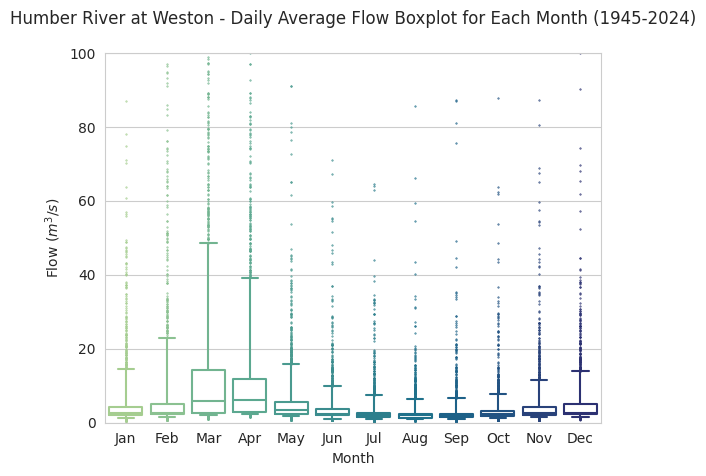

In [418]:
# Initialize a box plot with Seaborn
plt.figure()

# Set the order of the months
month_order = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Create the box plot
sns.boxplot(
    x="month_name",
    y="Flow",
    data=df,
    fliersize=0.5,
    order=month_order,
    palette="crest",
    fill=False,
    hue="month",
    legend=False,
    whis=[5, 95],
)

plt.title(
    "Humber River at Weston - Daily Average Flow Boxplot for Each Month (1945-2024)\n"
)
plt.xlabel("Month")
plt.ylabel("Flow ($m^3/s$)")

# set vertical axis limit
plt.ylim(0, 100)

plt.show()

In [419]:
# Show summary statistics for level and flow
df[["Level", "Flow"]].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).round(2)

,Level,Flow
count,36221.00,36221.00
mean,101.99,5.53
std,0.15,11.38
min,101.90,0.26
25%,101.94,2.10
50%,101.94,2.52
75%,101.98,4.82
95%,102.22,18.60
99%,102.79,52.30
max,105.12,838.00


In [420]:
# Show summary statistics for level by month
group_by_month = df.groupby(["month", "month_name"])

summary_stats = (
    group_by_month["Flow"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).round(2)
)

summary_stats.index = summary_stats.index.droplevel(
    0
)  # Remove the 'month_num' level from the index

# Drop unnecessary columns
summary_stats = summary_stats.drop(columns=["count", "std"])

# Display the table
display(summary_stats)

,mean,min,25%,50%,75%,95%,99%,max
month_name,,,,,,,,
Jan,4.96,0.60,2.22,2.58,4.36,14.61,42.22,221.0
Feb,6.60,0.82,2.25,2.63,4.98,23.06,70.67,204.0
Mar,12.92,1.08,2.66,5.95,14.30,48.61,94.52,218.0
Apr,11.16,1.59,2.94,6.15,11.80,39.10,79.64,206.0
May,5.48,0.85,2.32,3.41,5.66,15.90,36.00,161.0
Jun,3.78,0.67,2.04,2.34,3.70,9.90,25.24,151.0
Jul,3.09,0.26,1.55,2.14,2.72,7.53,22.20,175.0
Aug,2.69,0.40,1.39,2.06,2.42,6.55,15.37,118.0
Sep,2.84,0.40,1.46,2.07,2.42,6.76,19.90,171.0


## Calculate monthly exceedence probabilities

In [421]:
# Initialize an empty DataFrame to store the data for each month
df_with_exceedance = pd.DataFrame()

# Calculate exceedance probability for each month
for month in range(1, 13):
    monthly_data = monthly_peak_flow[monthly_peak_flow["month"] == month].sort_values(
        by="Flow", ascending=False  # sort in descending order
    )
    monthly_data["rank"] = range(1, len(monthly_data) + 1)  # create rank
    monthly_data["exceedance_probability"] = monthly_data["rank"] / (
        len(monthly_data) + 1  # calculate exceedance probability
    )

    # Append the monthly data to the DataFrame
    df_with_exceedance = pd.concat([df_with_exceedance, monthly_data])

# Display the resulting DataFrame
df_with_exceedance.tail()

,Flow,month,month_name,Level,rank,exceedance_probability
Date,,,,,,
1960-12-31,2.38,12.0,Dec,101.940644,74,0.936709
1952-12-31,2.07,12.0,Dec,101.935366,75,0.949367
1963-12-31,1.95,12.0,Dec,101.933323,76,0.962025
1958-12-31,1.73,12.0,Dec,101.929578,77,0.974684
1946-12-31,1.67,12.0,Dec,101.928556,78,0.987342


,mean,min,25%,50%,75%,95%,99%,max
month_name,,,,,,,,
Jan,27.16,0.89,6.16,13.60,35.65,106.30,146.26,221.0
Feb,41.20,1.30,6.28,21.00,66.40,142.40,182.54,204.0
Mar,73.82,8.30,40.58,67.65,97.30,139.70,188.74,218.0
Apr,52.78,3.54,22.38,49.55,76.72,120.20,157.49,206.0
May,25.96,2.07,9.09,16.60,28.85,82.67,131.74,161.0
Jun,16.20,1.19,5.45,8.18,16.20,58.83,89.48,151.0
Jul,17.07,1.46,4.79,7.64,17.32,47.02,149.59,175.0
Aug,12.32,1.39,3.30,8.75,12.95,35.28,93.21,118.0
Sep,11.19,1.59,3.14,5.43,10.10,28.32,98.50,171.0


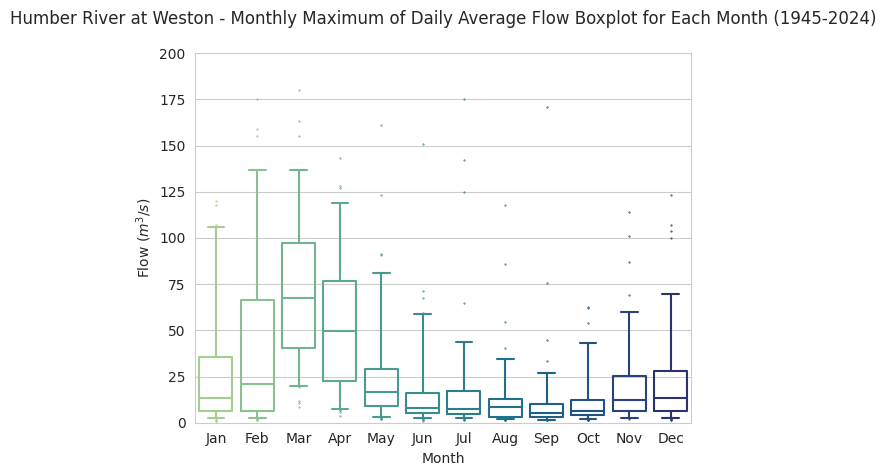

In [422]:
# Show summary statistics for level by month
group_max_by_month = df_with_exceedance.groupby(["month", "month_name"])

summary_stats_mm = (
    group_max_by_month["Flow"]
    .describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
    .round(2)
)

# Remove the 'month_num' level from the index
summary_stats_mm.index = summary_stats_mm.index.droplevel(0)

# Drop unnecessary columns
summary_stats_mm = summary_stats_mm.drop(columns=["count", "std"])
display(summary_stats_mm)

sns.boxplot(
    x="month_name",
    y="Flow",
    data=df_with_exceedance,
    fliersize=0.5,
    order=month_order,
    palette="crest",
    fill=False,
    hue="month",
    legend=False,
    whis=[5, 95],
)

# Set the title and axis labels
plt.title(
    "Humber River at Weston - Monthly Maximum of Daily Average Flow Boxplot for Each Month (1945-2024)\n"
)
plt.xlabel("Month")
plt.ylabel("Flow ($m^3/s$)")

# set vertical axis limit
plt.ylim(0, 200)

plt.show()

In [423]:
# Define the flow intervals
flow_intervals = range(20, 120, 20)

# Initialize a DataFrame to store the exceedance probabilities
exceedance_table = pd.DataFrame(index=range(1, 13), columns=flow_intervals)

# Calculate the exceedance probabilities for each month and flow level
for month in range(1, 13):
    for flow in flow_intervals:
        exceedance_table.loc[month, flow] = (
            df_with_exceedance[
                (df_with_exceedance["month"] == month)
                & (df_with_exceedance["Flow"] > flow)
            ].shape[0]
            / df_with_exceedance[df_with_exceedance["month"] == month].shape[0]
        )


# Display the table
exceedance_table

,20,40,60,80,100
1,0.413333,0.213333,0.093333,0.08,0.066667
2,0.52,0.4,0.28,0.146667,0.093333
3,0.935897,0.75641,0.551282,0.397436,0.217949
4,0.75641,0.564103,0.410256,0.217949,0.076923
5,0.384615,0.179487,0.115385,0.064103,0.025641
6,0.217949,0.115385,0.038462,0.012821,0.012821
7,0.192308,0.064103,0.051282,0.038462,0.038462
8,0.102564,0.051282,0.025641,0.025641,0.012821
9,0.12987,0.038961,0.025974,0.012987,0.012987
10,0.151899,0.063291,0.037975,0.012658,0.012658
